In [1]:
import os

import numpy as np
from netCDF4 import Dataset

import seaborn as sns
from tqdm import tqdm
from glob import glob
import pandas as pd
import time

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.client import device_lib

print(tf.__version__)
print(device_lib.list_local_devices())

2023-03-20 07:28:08.914337: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-20 07:28:09.128218: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


2.11.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8993312912149378656
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 23357161472
locality {
  bus_id: 1
  links {
  }
}
incarnation: 427447882489276664
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:19:00.0, compute capability: 8.6"
xla_global_id: 416903419
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 23090823168
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6717229250763378352
physical_device_desc: "device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1a:00.0, compute capability: 8.6"
xla_global_id: 2144165316
, name: "/device:GPU:2"
device_type: "GPU"
memory_limit: 23357161472
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3078102696138818310
physical_device_desc: "device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:67:00.0, compute capability: 8.6"
xla_global_id: 1651660799
, name: "/device

2023-03-20 07:28:10.830767: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-20 07:28:13.162989: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /device:GPU:0 with 22275 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:19:00.0, compute capability: 8.6
2023-03-20 07:28:13.163645: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /device:GPU:1 with 22021 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1a:00.0, compute capability: 8.6
2023-03-20 07:28:13.164163: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /device:GPU:2 with 22275 MB memory:  -> device: 2, name: NVIDIA GeForce RT

In [2]:
path = '/home/workspace'
data_path = os.path.join(path,'cmaqProjectdata')
proj_path = os.path.join(path,'repos','cmaqProject')

In [3]:
checkpoint_dir = os.path.join(proj_path,'models','training_checkpoints',"model_conmat_cmaq_1_checkpoint")
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint_prefix

'/home/workspace/repos/cmaqProject/models/training_checkpoints/model_conmat_cmaq_1_checkpoint/ckpt'

In [4]:
BATCH_SIZE = 8
EPOCH = 1
shuffle_buffer_size = 100
train_set_len = 100

INPUT_SHAPE = [119]
OUTPUT_CHANNELS = 1

## 데이터셋

In [5]:
avg_conc_path_list = glob(os.path.join(data_path,"연평균자료","concentration","*"))
avg_conc_path_info_df = pd.DataFrame()
avg_conc_path_info_df.loc[:,'path'] = avg_conc_path_list
avg_conc_path_info_df.loc[:,'Run'] = [int(path.split("/")[-1].split(".")[1]) for path in avg_conc_path_list]

cont_matrix = pd.read_csv(os.path.join(data_path,"연평균자료","02_Emission_0518.csv"))

merged_info_df = pd.merge(avg_conc_path_info_df, cont_matrix, how='left', on='Run')
target_arr = np.concatenate([np.array(Dataset(path, 'r').variables['PM2_5'][0,0,8:-10,2:-1])[np.newaxis,:,:] for path in merged_info_df.path.tolist()])[:,:,:,None]

In [6]:
target_arr.shape

(120, 64, 64, 1)

In [7]:
input_cols = list(set(merged_info_df.columns) - set(['path','Run',]))

train_input = merged_info_df.loc[:,input_cols].values[:train_set_len]
test_input = merged_info_df.loc[:,input_cols].values[train_set_len:]

train_output = target_arr[:train_set_len]
test_output = target_arr[train_set_len:]

train_input_ds = tf.data.Dataset.from_tensor_slices(train_input)
train_target_ds = tf.data.Dataset.from_tensor_slices(train_output)

test_input_ds = tf.data.Dataset.from_tensor_slices(test_input)
test_target_ds = tf.data.Dataset.from_tensor_slices(test_output)


train_ds = tf.data.Dataset.zip((train_input_ds, train_target_ds)).batch(BATCH_SIZE).shuffle(shuffle_buffer_size)
test_ds = tf.data.Dataset.zip((test_input_ds, test_target_ds)).batch(BATCH_SIZE).shuffle(shuffle_buffer_size)

# train_ds = ds.take(train_set_len) 
# test_ds = ds.skip(train_set_len)

2023-03-20 07:28:30.228072: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22275 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:19:00.0, compute capability: 8.6
2023-03-20 07:28:30.228366: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22021 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1a:00.0, compute capability: 8.6
2023-03-20 07:28:30.228632: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22275 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:67:00.0, compute capability: 8.6
2023-03-20 07:28:30.229115: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 21987 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3090

In [8]:
train_input.shape, test_input.shape, 

((100, 119), (20, 119))

In [9]:
train_output.shape, test_output.shape, 

((100, 64, 64, 1), (20, 64, 64, 1))

## 모델

In [10]:
class Downsample(tf.keras.layers.Layer):
    def __init__(self, filters, size, apply_batchnorm=True):
        super(Downsample, self).__init__()
        self.initializer = tf.random_normal_initializer(0., 0.02)
        self.layer_stack = []

        self.layer_stack.append(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                kernel_initializer=self.initializer, use_bias=False))
        if apply_batchnorm:
            self.layer_stack.append(tf.keras.layers.BatchNormalization())
        self.layer_stack.append(tf.keras.layers.LeakyReLU())


    def call(self, inputs):
        x = inputs
        for layer_id in self.layer_stack:
            x = layer_id(x)

        return x
    

class Upsample(tf.keras.layers.Layer):
    def __init__(self, filters, size, apply_dropout=False):
        super(Upsample, self).__init__()
        self.initializer = tf.random_normal_initializer(0., 0.02)
        self.layer_stack = []

        self.layer_stack.append(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=self.initializer,
                                    use_bias=False))
        self.layer_stack.append(tf.keras.layers.BatchNormalization())
        if apply_dropout:
            self.layer_stack.append(tf.keras.layers.Dropout(0.5))
        self.layer_stack.append(tf.keras.layers.ReLU())
        
    def call(self, inputs):
        x = inputs
        for layer_id in self.layer_stack:
            x = layer_id(x)
        return x
    


class Generator(tf.keras.Model): 
    def __init__(self,base_map): 
        super(Generator, self).__init__()

        self.base_map = base_map
        self.mulp_l = tf.keras.layers.Multiply()

        self.down_stack = [
            Downsample(64, 3),  # (batch_size, 64, 64, 64)
            Downsample(128, 3),  # (batch_size, 32, 32, 128)
            Downsample(256, 3),  # (batch_size, 16, 16, 256)
            Downsample(512, 3),  # (batch_size, 8, 8, 512)
            Downsample(512, 3),  # (batch_size, 4, 4, 512)
        ]

        self.up_stack = [
            Upsample(512, 3, apply_dropout=True),  # (batch_size, 4, 4, 1024)
            Upsample(512, 3),  # (batch_size, 8, 8, 1024)
            Upsample(256, 3),  # (batch_size, 16, 16, 512)
            Upsample(128, 3),  # (batch_size, 32, 32, 256)
            Upsample(64, 3),  # (batch_size, 64, 64, 128)
        ]

        self.initializer = tf.random_normal_initializer(0., 0.02)
        # self.last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,


        self.last_stack = [
            tf.keras.layers.Conv2DTranspose(64,4,
                                                strides=2,
                                                padding='same',
                                                kernel_initializer=self.initializer,
                                                ),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2D(32, 3,
                                                # strides=2,
                                                padding='same',
                                                kernel_initializer=self.initializer,
                                                ),
            # tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2D(1, 3,
                                                # strides=2,
                                                padding='same',
                                                kernel_initializer=self.initializer,
                                                ),
                                                
                                                ]
        
    
    def call(self, input): 
        # tf.linalg.matmul(batch[1],tf.keras.layers.Reshape((1,1, 119))(batch[0]))[0,:,:,0]
        x = input
        # x = pre_gen_layer(x)
        # x = mulp_l([x , inputs])
        # x = self.mulp_l([self.base_map , x])
        # x = data_augmentation(x)      
        x = tf.multiply(tf.keras.layers.Reshape((1,1, 119))(x), self.base_map)  # basemap shape == (64,64,1)

        # Downsampling through the model
        skips = []
        for down in self.down_stack:
            x = down(x)
            skips.append(x)

        skips = reversed(skips[:-1])

        # Upsampling and establishing the skip connections
        for up, skip in zip(self.up_stack, skips):
            x = up(x)
            x = tf.keras.layers.Concatenate()([x, skip])

        for last_layer in self.last_stack:
            x = last_layer(x)

        return x


In [11]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
loss_mse = tf.keras.losses.MeanSquaredError()
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = loss_mse(target, gen_output)

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [12]:
# 1번 시나리오 베이스맵으로 사용
base_map = np.array(Dataset(merged_info_df.loc[merged_info_df.Run == 1,'path'].values[0], 'r').variables['PM2_5'][0,0,8:-10,2:-1])[:,:,np.newaxis]
## 모델 체크포인트 생성
generator_optimizer = tf.keras.optimizers.Adam(0.001)
generator = Generator(base_map)

checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                #  discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                #  discriminator=discriminator
                                 )

# ####### 저장된 모델 있을 경우 ##########
# manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)
# checkpoint.restore(manager.latest_checkpoint)

In [13]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(8, 8))
  # display_list = [test_input[0][0][:,:,:3], tar[0][:,:,0][::-1], prediction[0][::-1]]
  # title = ['Input', 'Ground Truth', 'Predicted Image']
  print(prediction.shape, tar.shape)
  display_list = [tar[0][::-1], prediction[0][::-1]]
  title = ['Ground Truth', 'Predicted Image']
  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

1


2023-03-20 07:29:14.268898: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101


(1, 64, 64, 1) (1, 64, 64, 1)


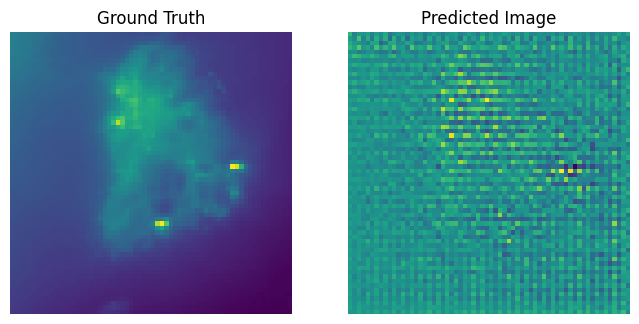

In [14]:
for batch in test_ds.take(1):
    print(1)
generate_images(generator, batch[0][0:1], batch[1][0:1])

* 학습

In [15]:
from IPython import display

In [16]:
import datetime
summary_writer = tf.summary.create_file_writer(os.path.join(checkpoint_prefix, "logs", "fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))

Time taken for 100 steps: 2.06 sec

(8, 64, 64, 1) (8, 64, 64, 1)


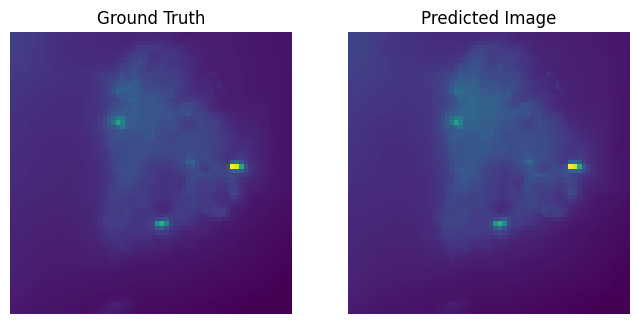

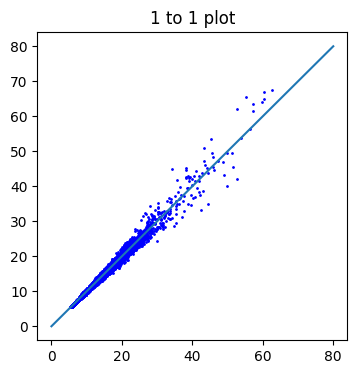

Step: 4900
..........

In [17]:
@tf.function
def train_step(input_image, target, step):
  # with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
  with tf.GradientTape() as gen_tape:
    gen_output = generator(input_image, training=True)
    l1_loss = loss_mse(target, gen_output)
  generator_gradients = gen_tape.gradient(l1_loss,
                                          generator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  # discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
  #                                             discriminator.trainable_variables))
  # with summary_writer.as_default():
  #   tf.summary.scalar('gen_total_loss', gen_total_loss, step=step)
  #   tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step)
  #   tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step)
  #   tf.summary.scalar('disc_loss', disc_loss, step=step)

steps = 5000
generator_optimizer = tf.keras.optimizers.Adam(0.0001)

start = time.time()

for step, (input_arr, target) in train_ds.repeat().take(steps).enumerate():
  
  if (step) % 100 == 0:
    display.clear_output(wait=True)

    if step != 0:
      print(f'Time taken for 100 steps: {time.time()-start:.2f} sec\n')

    start = time.time()

    generate_images(generator, example_input, example_target)
    results = generator(test_input)
    

    plt.figure(figsize=(4, 4))
    
    plt.subplot(1, 1, 1)
    plt.title('1 to 1 plot')
    plt.plot(results.numpy().reshape(-1), test_output.reshape(-1),'bo', markersize=1)
    plt.plot([0,80],[0,80])
    # plt.axis('off')

    plt.show()

    print(f"Step: {step}")

  train_step(input_arr, target, step)

  # Training step
  if (step+1) % 10 == 0:
    print('.', end='', flush=True)


  # Save (checkpoint) the model every 5k steps
  if (step + 1) % 1000 == 0:
    checkpoint.save(file_prefix=checkpoint_prefix)

* 평가

In [18]:
results = generator(test_input)

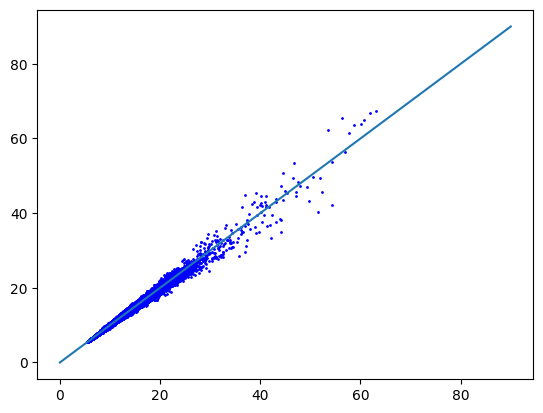

In [19]:
plt.plot(results.numpy().reshape(-1), test_output.reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

In [20]:
train_results = generator(train_input)

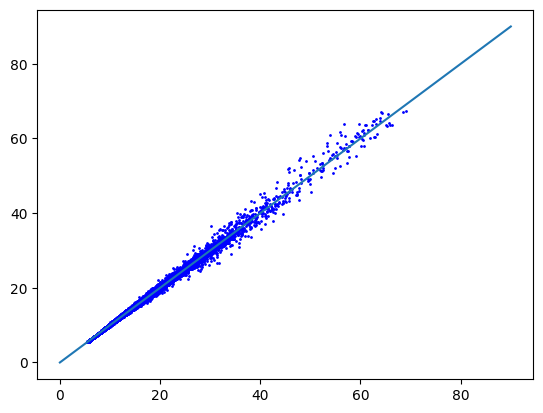

In [21]:
plt.plot(train_results.numpy().reshape(-1), train_output.reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

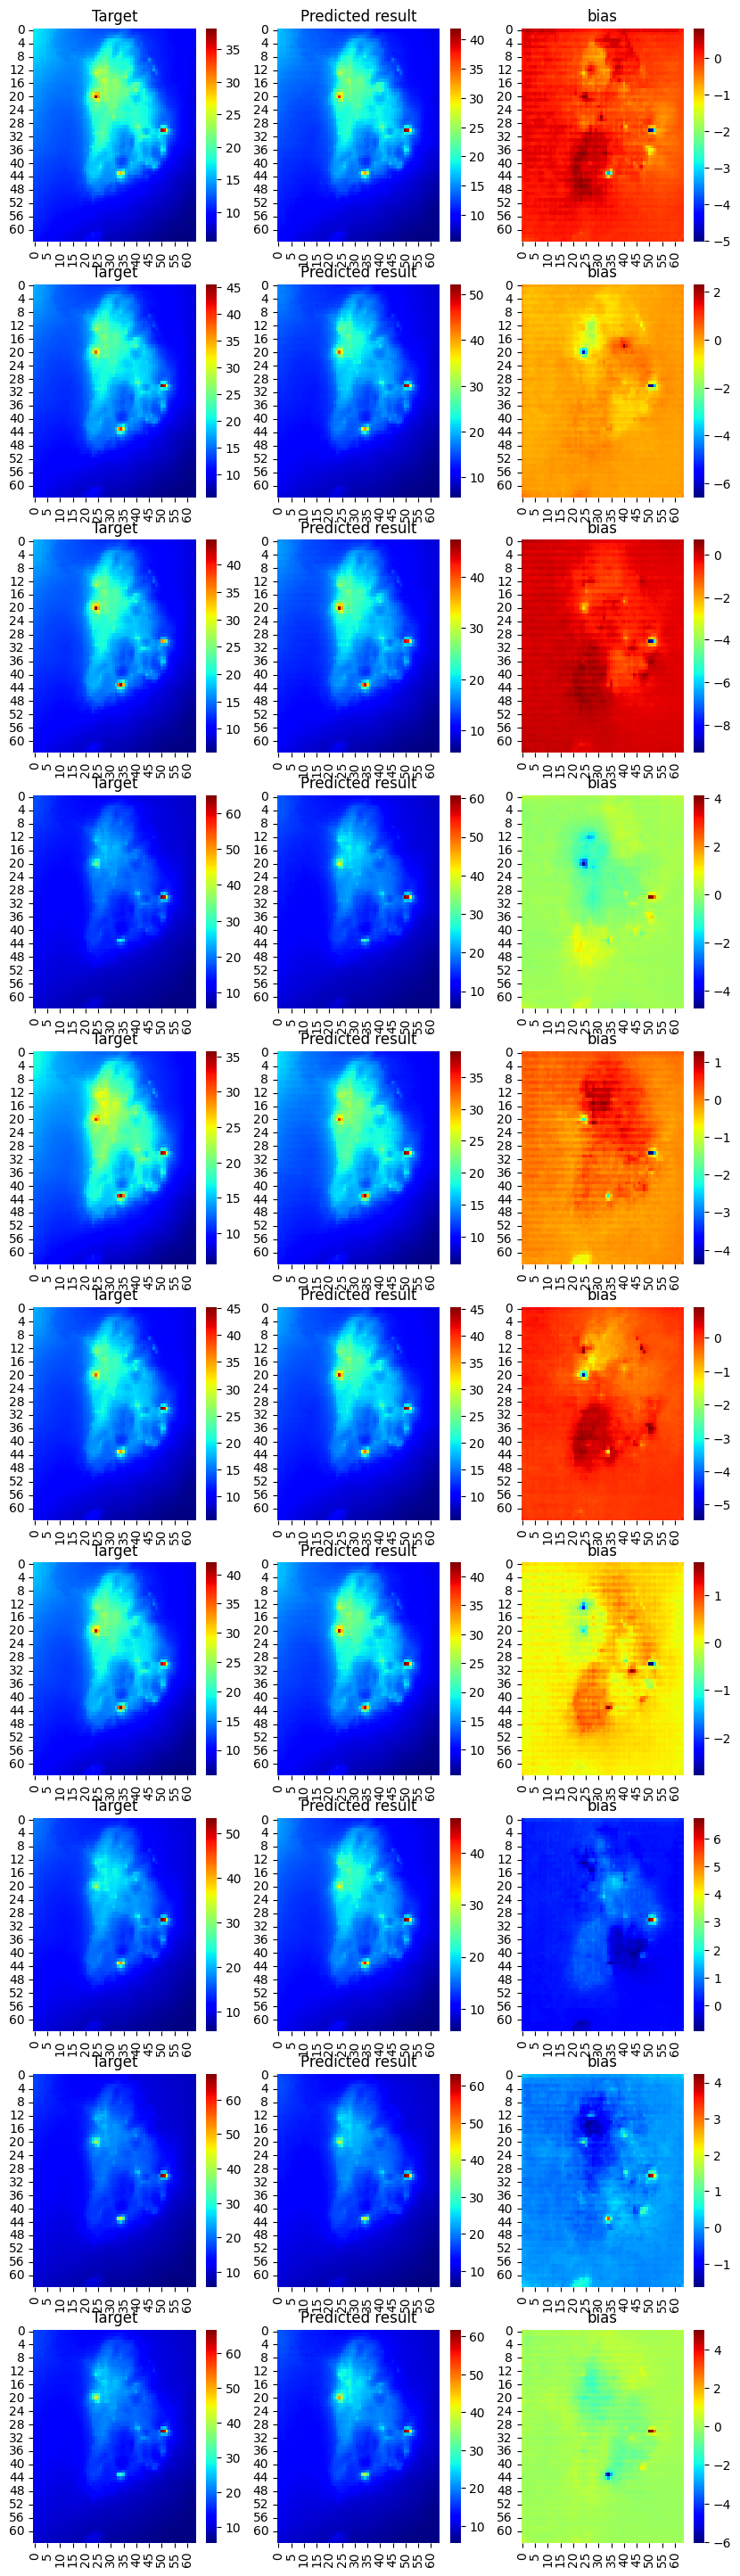

In [22]:
plt.figure(figsize=(10, 15*30))
j = 0

results = generator(test_input)
for i in range(len(results))[:10]:
  
  display_list = [test_output[i], results[i], test_output[i] - results[i]]
  title = ['Target','Predicted result', 'bias']
  
  for i in range(3):
    plt.subplot(121, 3, j + i + 1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    # plt.imshow(display_list[i][:,:,0][::-1])
    sns.heatmap(display_list[i][:,:,0][::-1], cmap='jet')
    # if i != 2:
    #   sns.heatmap(display_list[i][:,:,0][::-1], cmap='jet', vmax=80,vmin=0)
    # else:
    #   sns.heatmap(display_list[i][:,:,0][::-1], cmap='jet')
    # plt.axis('off')
  j += 3